# NYC Property sale data analysis

In [1]:
import numpy as np
import pandas as pd
import datetime

from datascience import *
from datetime import timedelta
from datetime import date
from datetime import datetime


# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')



import locale

In [2]:
# Helpers Functions

def print_stats(data): 
    '''Prints common stats for a data array'''
    
    data_mean = np.mean(data)
    data_std = np.std(data)
    data_min = min(data)
    data_max = max(data)

    percent_5 = percentile(5, data)
    percent_95 = percentile(95, data)
    percent_1 = percentile(1, data)
    percent_99 = percentile(99, data)
    
    percent_25 = percentile(25, data)
    percent_50 = percentile(50, data)
    percent_75 = percentile(75, data)

    print("Avg:", data_mean, "\tStd:", data_std, "\tMin:", data_min, "\tMax:", data_max)
    print(" 5%:", percent_5, "\t95%:", percent_95)
    print(" 1%:", percent_1, "\t99%:", percent_99)
    print("25%:", percent_25, "\t50%:", percent_50, '\t75%', percent_75)
    

def print_col_stats(table, col_name):
    ''' Print the stats For column named'''
    
    print(col_name + "Stats")
    data = table.column(col_name)
    print_stats(data)
    
def draw_hist(table : Table, col_name, offset_percent=0):
    ''' Draw a histogram for table with an additional offset percent'''
    data = table.column(col_name)
    offset_start = percentile(offset_percent, data)
    offset_end = percentile(100-offset_percent, data)
    table.hist(col_name, bins=np.arange(offset_start, offset_end, (offset_end-offset_start)/20))
               
def col_stats(table, col_name):
    ''' Prints state for a column in table'''
    print_col_stats(table, col_name)
    draw_hist(table, col_name)
               

   

In [3]:
# helpers

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

In [4]:
# Declare column names to allow for auto completion :)

COL_SALE_DATE = 'SALE DATE'

COL_FIRST_SALE_DATE = 'FIRST SALE'
COL_LAST_SALE_DATE = 'LAST SALE'
COL_FIRST_SALE_PRICE = 'FIRST PRICE'
COL_LAST_SALE_PRICE = 'LAST PRICE'
COL_FULL_ADDRESS = 'FULL ADDRESS'
COL_PRICE_CHANGE = 'PRICE CHANGE'
COL_PERIOD = 'PERIOD'

COL_SALE_YEAR = 'SALE_YEAR'
COL_SALE_MONTH = 'SALE_MONTH'
COL_SALE_PRICE = 'SALE PRICE'

In [5]:
csv_directory = "data/csv/"

# Import Data

# All Condos
df = pd.read_csv(csv_directory+'condos.csv')

#SALE DATE is object but should be datetime
df[COL_SALE_DATE] = pd.to_datetime(df[COL_SALE_DATE], errors='coerce')

df = df.applymap(lambda x: x.strip() if type(x) is str else x)



condos = Table.from_df(df)

# Multi Sale Condos 

df = pd.read_csv(csv_directory+'condo_sales.csv')

# DATE is object but should be datetime
df[ COL_FIRST_SALE_DATE] = pd.to_datetime(df[COL_FIRST_SALE_DATE], errors='coerce')
df[ COL_LAST_SALE_DATE] = pd.to_datetime(df[COL_LAST_SALE_DATE], errors='coerce')

condo_sales = Table.from_df(df)


# Understanding the data

Let's try to get an overview of the data by looking at the movement of the average sale price per year.

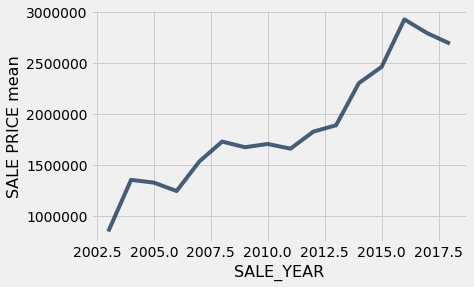

In [6]:
years = [ d.year for d in condos.column(COL_SALE_DATE) ]

months = [ d.month for d in condos.column(COL_SALE_DATE) ]

condos = condos.with_column('SALE_YEAR', years, 'SALE_MONTH', months)

condo_mean = condos.select(COL_SALE_YEAR, COL_SALE_PRICE).group(COL_SALE_YEAR, np.mean).sort(0)
condo_mean.plot(COL_SALE_YEAR)



## Sales by neighbourhood 

Also helpful to usederstand how prices have changed in different neighborhoods. 

In [7]:


neighborhoods = condos.group('NEIGHBORHOOD').sort(1, descending=True)

neighborhoods
# condos.select('NEIGHBORHOOD', COL_SALE_YEAR, COL_SALE_PRICE).groups(['NEIGHBORHOOD', COL_SALE_YEAR], np.mean).pivot(0, 1,  values=2, collect=np.mean).plot(0)

def plot_neighborhood(neighborhood:str):
    '''Plot the average sale for a specide'''
    condos.where('NEIGHBORHOOD', are.equal_to(neighborhood)).select(COL_SALE_YEAR, COL_SALE_PRICE).group(0, np.mean).plot(0, label=neighborhood)
    plots.title = neighborhood
    plots.plot(condo_mean.column(0), condo_mean.column(1), color='gold', label='line 1' )
    
# plot_neighborhood(neighborhoods[0])

interact(plot_neighborhood, neighborhood=neighborhoods.sort(0).column(0))


interactive(children=(Dropdown(description='neighborhood', options=('ALPHABET CITY', 'CHELSEA', 'CHINATOWN', '…

<function __main__.plot_neighborhood(neighborhood: str)>

Let's take a deeper dive at apartment sales in 2010 as a sample. Note: we could have selected any range. This is just a random selection to reduce the noise in the data



Correlation betweeen Price Change and Time:  0.12950919409279943


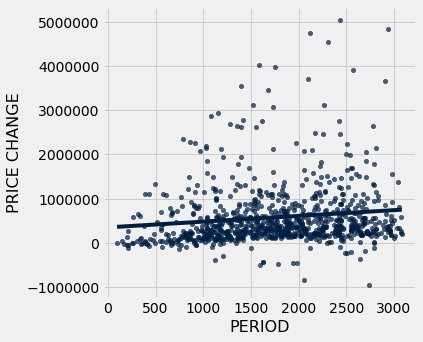

In [8]:
sales_2010 = condo_sales.where(COL_FIRST_SALE_DATE, are.between( datetime(2010, 1, 1), datetime(2010, 12, 31)))

Table().with_columns(
    'PERIOD',  sales_2010.column(COL_PERIOD), 
    'PRICE CHANGE', sales_2010.column(COL_PRICE_CHANGE)
).scatter(0, 1, fit_line=True)

print('Correlation betweeen Price Change and Time: ', correlation(sales_2010, COL_PERIOD, COL_PRICE_CHANGE))

Hmm that's a low correlation, the expectations much higher, roughly keeping in line with avg overall sale price we plotted earlier.


Ok, let's look at the correlation between the first and last sale price. 

0.9481282677701287

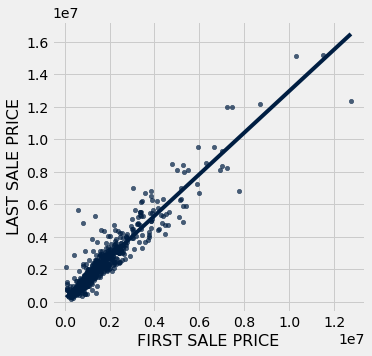

In [9]:
Table().with_columns(
    'FIRST SALE PRICE',  sales_2010.column(COL_FIRST_SALE_PRICE), 
    'LAST SALE PRICE', sales_2010.column(COL_LAST_SALE_PRICE)
).scatter(0, fit_line=True)

correlation(sales_2010, COL_FIRST_SALE_PRICE, COL_LAST_SALE_PRICE)



Wow that's a really high correlation. According to this we could predict the last sale price of a property, just based on it's first sale price. i.e. independent of the time between sales! 

Somehting doesn't seem right. Let's dig in a little deeper. 

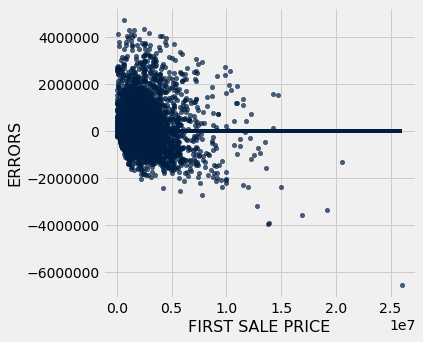

In [10]:
# Let Look at the residuals


a = slope(condo_sales, COL_FIRST_SALE_PRICE, COL_LAST_SALE_PRICE)
b = intercept(condo_sales, COL_FIRST_SALE_PRICE, COL_LAST_SALE_PRICE)

first_prices = condo_sales.column(COL_FIRST_SALE_PRICE)

predicted = first_prices * a + b

errors = condo_sales.column(COL_LAST_SALE_PRICE) - predicted


Table().with_columns(
    'FIRST SALE PRICE',  condo_sales.column(COL_FIRST_SALE_PRICE), 
    'ERRORS', errors
).scatter(0, fit_line=True)

# The residuals are unevenly spread-out, so a liner regression model isn't enough



# Price change % 

In [11]:
# Lets calculate the price change as a percentage of the original price and plot that. 

percents = sales_2010.column(COL_PRICE_CHANGE) / sales_2010.column(COL_FIRST_SALE_PRICE) * 100

COL_PRICE_PERCENT = 'PRICE CHANGE %'

sales_2010 = sales_2010.with_column(COL_PRICE_PERCENT, percents)



## Sanitize price change % 

Looking into how  the price change % data is distributed. 

PRICE CHANGE %Stats
Avg: 53.35357017034671 	Std: 129.39169442541132 	Min: -60.02098971213591 	Max: 3054.111347465708
 5%: 0.0 	95%: 103.81328073635765
 1%: -29.6875 	99%: 487.8787878787879
25%: 23.544303797468356 	50%: 39.24050632911392 	75% 57.05128205128205


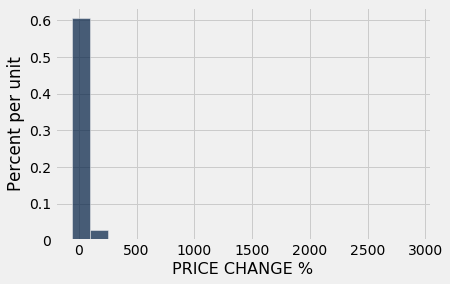

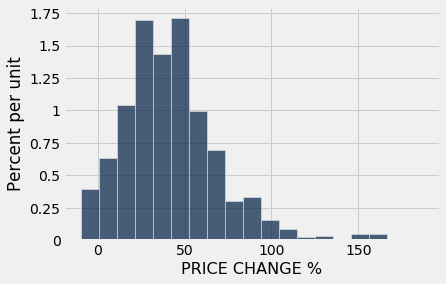

In [12]:

col_stats(sales_2010, COL_PRICE_PERCENT)
draw_hist(sales_2010, COL_PRICE_PERCENT, 2)

Looks like most of the data is between, 0 to 200%. But some outliers will obstruct our analysis. Let's filter out the outliers

In [13]:
# strip out the Price Percent change outliers. 

price_changes = sales_2010.column(COL_PRICE_PERCENT)

percent_2 = percentile(2, price_changes)
percent_98 = percentile(98, price_changes)

sales_2010 = sales_2010.where(COL_PRICE_PERCENT, are.between(percent_2, percent_98))



0.33006786771399327

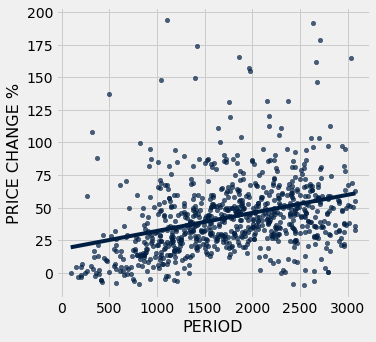

In [14]:
sales_2010.scatter(COL_PERIOD, COL_PRICE_PERCENT, fit_line=True)
correlation(sales_2010, COL_PERIOD, COL_PRICE_PERCENT)

Ok there ther definitely looks to be a tigher upward trend here and prices increase over time. Smoothing the data into monthly (30) intervals look like the following

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


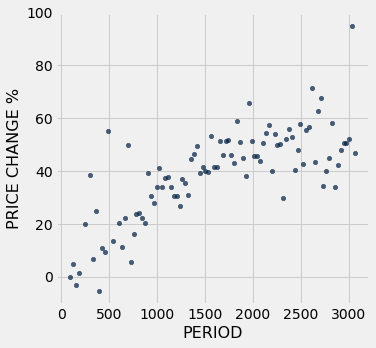

In [15]:

periods = sales_2010.column(COL_PERIOD)

min_period = min(periods)
max_period = max(periods)


period_groups = []
period_sales = []

for i in np.arange(min_period, max_period, 30 ):
    period_groups.append(i)
    period_sales.append(np.mean(sales_2010.where(COL_PERIOD, are.between(i, i+30)).column(COL_PRICE_PERCENT)))
    

Table().with_columns(
    COL_PERIOD,  period_groups, 
    COL_PRICE_PERCENT, period_sales
).scatter(0)

In [16]:
# Interact with price changes for other years

percents = condo_sales.column(COL_PRICE_CHANGE) / condo_sales.column(COL_FIRST_SALE_PRICE) * 100

condo_sales = condo_sales.with_column(COL_PRICE_PERCENT, percents)

percent_1 = percentile(1, percents)
percent_99 = percentile(99, percents)

condo_sales = condo_sales.where(COL_PRICE_PERCENT, are.between(percent_1, percent_99))


def plot_price_change_year(year):
    ''' Plot the price change % for a given year'''
    valid_sales = condo_sales.where(COL_FIRST_SALE_DATE, are.between_or_equal_to( datetime(year, 1, 1), datetime(year+1, 1, 1)))

    min_period = min(periods)
    max_period = max(periods)


    period_groups = []
    period_sales = []

    for i in np.arange(min_period, max_period, 30 ):
        period_groups.append(i)
        period_sales.append(np.mean(valid_sales.where(COL_PERIOD, are.between(i, i+30)).column(COL_PRICE_PERCENT)))

    Table().with_columns(
        COL_PERIOD,  period_groups, 
        COL_PRICE_PERCENT, period_sales
    ).scatter(0)

interact(plot_price_change_year, year=np.arange(2003,2019) )



interactive(children=(Dropdown(description='year', options=(2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 20…

<function __main__.plot_price_change_year(year)>

We can now say there is a a correlation between the price change and time reflective of the overall movement in the market over time. 

Let's create some prediction models. 

# Predicting NYC property prices

## Model 1: Linear Regression 


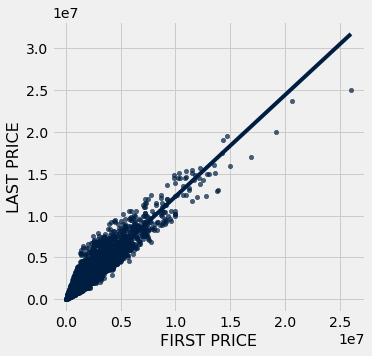

In [17]:
condo_sales.scatter(COL_FIRST_SALE_PRICE, COL_LAST_SALE_PRICE, fit_line=True)

In [18]:
def predict_using_linear_regression(price: int):
    '''Predict the last sale price using liner regression'''
    a = slope(condo_sales, COL_FIRST_SALE_PRICE, COL_LAST_SALE_PRICE)
    b = intercept(condo_sales, COL_FIRST_SALE_PRICE, COL_LAST_SALE_PRICE)
#     print(a, b)

    return '${:,.0f}'.format( np.floor( price * a + b ))

In [19]:
interact(predict_using_linear_regression, price=750000)

interactive(children=(IntSlider(value=750000, description='price', max=2250000, min=-750000), Output()), _dom_…

<function __main__.predict_using_linear_regression(price: int)>

## Model 2: Prediction model

Our prediction model should use both the purchase price and the sale price for prediction. Let's create it now.

In [52]:
def predict_sale_price(first_price, date: datetime):
    """Return a prediction of the sale price"""
    
    repetitions = 1000
    predictions = make_array()
    
    close_points = condo_sales.where(
            COL_FIRST_SALE_DATE, are.between(date - timedelta(days=90), date+timedelta(days=90))).where(
            COL_LAST_SALE_DATE, are.above(datetime.now() - timedelta(days=180))
        )
    
    for i in np.arange(repetitions):

        
        if close_points.num_rows > 0:
            avg_change = np.mean(close_points.sample(int(close_points.num_rows /2)).column(COL_PRICE_PERCENT))
            predictions = np.append(predictions, first_price * (100 + avg_change) / 100)
            
#     print(predictions)
    
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
   
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
#     plots.xlabel('predictions at x='+str(new_x))
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
#     print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)


Approximate 95%-confidence interval:
888370.9521828752 1032629.1847111203


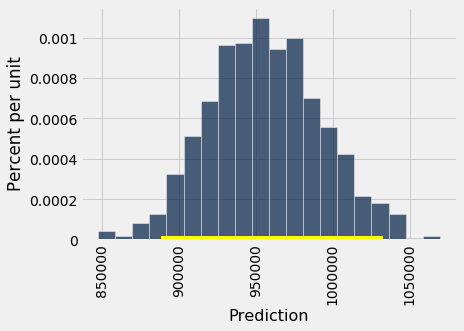

In [53]:
predict_sale_price(685000, datetime(2012,11,1))

# condo_sales.sample( int(condo_sales.num_rows / 2), with_replacement=False)

# condo_sales.

In [22]:
predictions = sales_2010.apply(predict_sale_price, COL_FIRST_SALE_PRICE)

Table().with_columns(
    COL_FIRST_SALE_PRICE,  sales_2010.column(COL_FIRST_SALE_PRICE), 
    COL_LAST_SALE_PRICE, sales_2010.column(COL_LAST_SALE_PRICE), 
    'PREDICTIONS', predictions
).scatter(COL_FIRST_SALE_PRICE)


TypeError: predict_sale_price() missing 1 required positional argument: 'date'

In [ ]:
interact(predict_sale_price, first_price=750000)